# Transformation visuelle pour reconstruction d'image corporelle

## Objectifs
L'objectif est d'améliorer le code de network2_01.py. 
Plusieurs pistes d'amélioration sont possibles:
1. Utiliser un produit tensoriel plutôt qu'un produit terme à terme.
2. Différencier la cible de la main.
3. Intégerer tf.
4. changer la répartition des points. 

Je m'inspire du papier de Memisevic, Gradient-based learning of higher-order image features et de son code gatedAutoencoder.py.

## Imports et setup





In [1]:
from numpy import *
from matplotlib.pylab import *
from mpl_toolkits.mplot3d import Axes3D
from drawnow import *
from skimage.draw import line, line_aa

import time 
import random
import scipy
import math
import cv2
import cPickle as pickle

import keras


Using TensorFlow backend.


In [2]:
matplotlib.rcParams.update({'font.size':16})
to_backup = True
timeframe = time.strftime('%Y%m%d%H%M%S')
L1 = 32
L2 = 16
L3 = 8

nb_posture = 30
nb_command = 10
nb_joint = 3
nb_data = nb_command*nb_posture
img_size = 128

## Construction de la base de données

1. On génère n postures différentes aléatoirement, X.
2. On génère m commandes aléatoirement, H. 
3. On applique chaque commande à chaque posture et on obtient des nouvelles postures Y.

### Génération des postures initiales

In [3]:
def randrange(n , vmin, vmax):
    return (vmax-vmin)*rand(n) + vmin 

In [4]:
posture = zeros((nb_posture, 3))
posture[:,0] = randrange(nb_posture, 0, pi)
posture[:,1] = randrange(nb_posture, 0, pi)
posture[:,2] =randrange(nb_posture, 0, pi)

In [5]:
print(shape(posture))
print(posture[0])

(30, 3)
[0.61314604 0.24409073 1.33362185]


### Génération des commandes 

In [6]:
command = zeros((nb_command, 3))
command[:,0] = randrange(nb_command, 0, 1)
command[:,1] = randrange(nb_command, 0, 1)
command[:,2] =randrange(nb_command, 0, 1)

In [7]:
print(shape(command))
print(command[0])
print(randint(0,nb_command-1))

(10, 3)
[0.69220099 0.82279587 0.84905916]
6


### Génération des données d'entraînement

In [8]:
train_data_x = zeros((nb_data, 1, 3))
train_data_y = zeros((nb_data, 1, 3))
train_data_h = zeros((nb_data, 1, 3))

In [9]:
print(train_data_x[0][0])
print(shape(train_data_x))

[0. 0. 0.]
(300, 1, 3)


In [10]:
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_x[idx] = posture[i]
        idx = idx + 1

idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_y[idx] = posture[i]  + command[j]
        idx = idx + 1
        
idx = 0 
for i in range(nb_posture):
    for j in range(nb_command):
        train_data_h[idx] = command[j]
        idx = idx + 1

In [11]:
print('train_data_x 0 0 ', train_data_x[0][0])
print('train_data_h 0 0 ', train_data_h[0][0])
print('train_data_y 0 0 ', train_data_y[0][0])
print('y = x + h')

('train_data_x 0 0 ', array([0.61314604, 0.24409073, 1.33362185]))
('train_data_h 0 0 ', array([0.69220099, 0.82279587, 0.84905916]))
('train_data_y 0 0 ', array([1.30534703, 1.0668866 , 2.18268101]))
y = x + h


### Génération des images associées

In [12]:
train_images_x = zeros((nb_data, 1, 128, 128), dtype = uint8)
train_images_y = zeros((nb_data, 1, 128, 128), dtype = uint8)

In [13]:
for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_x[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(img_size//2,img_size//2,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    img[r1,c1] = val1*255
    img[r2,c2] = val2*255
    img[r3,c3] = val3*255
    train_images_x[i][0] = img 

for i in range(nb_data):
    img = zeros((img_size,img_size), dtype = uint8)
    angle = train_data_y[i][0] 
    row1, col1 = img_size//2 + int(floor(L1*sin(angle[0]))), img_size//2 + int(floor(L1*cos(angle[0])))
    row2, col2 =  int(floor(L2*sin(angle[1]))) + row1, col1 + int(floor(L2*cos(angle[1])))
    row3, col3 = int(floor(L3*sin(angle[2])))+ row2, col2 +  int(floor(L3*cos(angle[2])))
    r1, c1, val1 = line_aa(64,64,row1, col1)
    r2, c2, val2 = line_aa(row1, col1, row2, col2)
    r3, c3, val3 = line_aa(row2, col2, row3 , col3)
    img[r1,c1] = val1*255
    img[r2,c2] = val2*255
    img[r3,c3] = val3*255
    train_images_y[i][0] = img 

On peut rajouter une gaussienne au bout de l'effecteur pour le mettre en évidence
TODO

In [14]:

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.
    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """
    x = arange(0, size, 1, float)
    y = x[:,newaxis]
    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]    
    return exp(-4*log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


### Exemples d'images

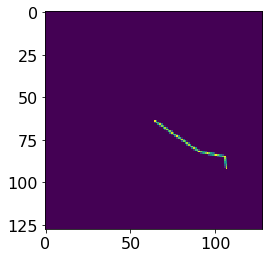

In [15]:
imshow(train_images_x[0][0])

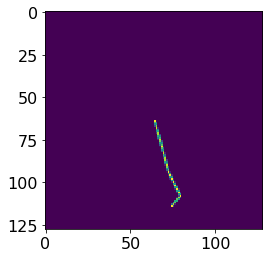

In [16]:
imshow(train_images_y[0][0])

## Factorized Gated Field Auto-encoder

Avant le passge dans l'autoencodeur, les images sont factorisées en passant par une couche de percpetron à une couche. De même, la couche latente est factorisée.
Les images sont de taille (128,128), on prend pour commencer 64 neurones. 
La sortie est de taille (3,1) (trois moteurs), on prend pour commencer une factorisation de taille (32,1) (synérgies motrices).

On a donc un encodeur, un décodeur et 3 couches de perceptrons pour les deux images et pour les commandes motrices.

On commence par construire un auto encodeur dont les entrées sont un tenseur de taille (32,32) et de sortie (32,1), pour garder la symétrie de la structure.


In [17]:
from keras.models import Model
from keras.layers import Activation, Dense, Input, Multiply
from keras.layers import Conv2D, Flatten, Reshape, Dot, Lambda
from keras import backend as K


### Création du modèle 

In [23]:
input_size = 128
input_shape = (input_size, input_size, 2)
latent_dim = 32

# on donne en entrée des pairs d'images
inputs_xy = Input(shape = (128,128,2), name = 'xy')

# on sépare chacune des images
x = Lambda(lambda x: x[:,:,:,0])(inputs_xy)
x = Reshape((128,128,1,))(x)

y = Lambda(lambda x: x[:,:,:,1])(inputs_xy)
y = Reshape((128,128,1,))(y)

print('taille initiale inputs_xy', K.int_shape(inputs_xy))
print('taille intiale de x', K.int_shape(x))
print('taille initiale de y', K.int_shape(y))

# on factorise chacune des images
fx = Flatten()(x)
fx = Dense(latent_dim, activation = 'relu', name = 'latent_fx')(fx)
fx = Reshape((32,1,))(fx)

fy = Flatten()(y)
fy = Dense(latent_dim, activation = 'relu', name = 'latent_fy')(fy)
fy = Reshape((32,1,))(fy)

# on multiplie les deux factorisations, mieux si produit tensoriel
matmul = Multiply()([fx, fy])


print('taille inter fx', K.int_shape(fx))
print('taille inter fy', K.int_shape(fy))
print('taill inter matmul', K.int_shape(matmul))

# on passe le tout dans un perceptron pour obtenir les synérgies motrices
x = Flatten()(matmul)
fh = Dense(latent_dim, name = 'latent_fh')(x)

# on passe des synérgies motrices aux actionneurs
latent = Dense(3, activation = 'sigmoid',  name = 'latent_vector')(fh)
latent = Reshape((3,1,))(latent)
print('taille latent', K.int_shape(latent))

encoder = Model(inputs = inputs_xy, outputs = latent, name = 'encoder')
encoder.summary()

('taille initiale inputs_xy', (None, 128, 128, 2))
('taille intiale de x', (None, 128, 128, 1))
('taille initiale de y', (None, 128, 128, 1))
('taille inter fx', (None, 32, 1))
('taille inter fy', (None, 32, 1))
('taill inter matmul', (None, 32, 1))
('taille latent', (None, 3, 1))
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
xy (InputLayer)                 (None, 128, 128, 2)  0                                            
__________________________________________________________________________________________________
lambda_10 (Lambda)              (None, 128, 128)     0           xy[0][0]                         
__________________________________________________________________________________________________
lambda_11 (Lambda)              (None, 128, 128)     0           xy[0][0]                         
_________________________